In [1]:
#creating extra data from current files  

import pandas as pd
import os
from datetime import datetime
from packaging import version
from keras.callbacks import EarlyStopping, ModelCheckpoint 
import tensorboard

Using TensorFlow backend.


AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [ ]:
root_path = ''
list_of_files = []
for root, dir,files in os.walk('/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data Context'):
  root_path = root
  list_of_files = files
  break 



In [ ]:
all_dataframes = []
for filename in list_of_files:
  file_path = root_path + '/' + filename
  file_temp = pd.read_csv(file_path)
  #print(file_temp.shape)
  temp_left = file_temp['Sentence']
  empty_left_first = pd.Series('')
  #print(type(temp_left))
  #print(empty_left_first.shape)
  file_temp['context_left'] = empty_left_first.append(temp_left,ignore_index=True)[:-1]
  #print(file_temp.head())
  temp_right = file_temp['Sentence'][1:]
  #print(len(file_temp))
  empty_right = pd.Series('')
  file_temp['context_right'] = temp_right.append(empty_right,ignore_index=True)
  print(file_temp.iloc[-1])
  all_dataframes.append(file_temp)


  


  

Sentence ID                                     F1312279794560_S72
Label                                              procedural fact
Sentence         In terms of the provisions of Rule 6 of the Ad...
context_left               Accordingly, the matter is disposed of.
context_right                                                     
Name: 71, dtype: object
Sentence ID                                     F1288673034598_S72
Label                                              procedural fact
Sentence         In terms of the provisions of Rule 6 of the Ad...
context_left               Accordingly, the matter is disposed of.
context_right                                                     
Name: 71, dtype: object
Sentence ID                                     F1289452697301_S46
Label                                              procedural fact
Sentence         In terms of the Rule 6 of the Adjudicating Rul...
context_left     The said demand draft should be forwarded to S...
context_right 

In [ ]:
result = pd.DataFrame()
result = result.append(all_dataframes,ignore_index=True)

In [ ]:
#can combine left and right context
result['Context'] = result['context_left'] + ' '+result['context_right']

In [ ]:
!pip install bert-for-tf2 

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=9fe353f7f02f9828a49a305f45c1278b40c42d3a65bc24f2d1a025d479d1c4dd
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=b526976d8487d20d8dc9158bec4acccb30196b9fa27818acdd2f5dc295040e96
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=059854fb51fcbdc4bdc1726314ba419137ed8f78417576cf6acb52ac752c295e
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
train_data = pd.DataFrame(columns= result.columns)
test_data = pd.DataFrame(columns=result.columns)
for label in result.Label.unique():
  temp_df = result[result['Label'] == label]
  train_index = int(temp_df.shape[0]*0.793)
  train_data = train_data.append(temp_df[:train_index])
  test_data = test_data.append(temp_df[train_index:])
  
  

In [ ]:
#drop sentence ID, context_left and context right 
train_data.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)
#valid_df.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)
test_data.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)

,Label,Sentence,Context
1714,material fact,"l. Thus, the inter-se transfer of shares amon...","Further, as per the C.A Certificate dated Marc..."
1717,material fact,I find from the records that the Noticees are ...,"m. In the circumstances, the impugned transact..."
1718,material fact,The Promoter group and or PACs together during...,I find from the records that the Noticees are ...
1722,material fact,In present case the Noticees along with other...,The first condition which is in issue is that ...
1723,material fact,The said purchase transactions were executed a...,In present case the Noticees along with other...
...,...,...,...
1049,penalty,28. Considering the facts and circumstances of...,I have also taken into account the submissions...
1050,penalty,After taking into consideration all the facts ...,28. Considering the facts and circumstances of...
1767,penalty,Violation of the above provisions attracts pe...,Considering the facts and circumstances of the...
1775,penalty,In view of the findings hereinabove and on tak...,The amount of disproportionate gain or unfair ...


In [ ]:
train_data['Label'].value_counts()

defendant claim           471
material fact             429
procedural fact           254
subjective observation    225
statutory fact            148
issues framed              75
related fact               68
allegation                 65
penalty                    33
violation                  24
Name: Label, dtype: int64

In [ ]:
#Repeat same data processing steps for new data (validated data)

vroot_path = ''
vlist_of_files = []
for root, dir,files in os.walk('/content/drive/MyDrive/SEBI /Adjudication Orders Annotations JSON/Model Data Validation Context'):
  vroot_path = root
  vlist_of_files = files


vall_dataframes = []
for filename in vlist_of_files:
  file_path = vroot_path + '/' + filename
  file_temp = pd.read_csv(file_path)
  #print(file_temp.shape)
  temp_left = file_temp['Sentence']
  empty_left_first = pd.Series('')
  #print(type(temp_left))
  #print(empty_left_first.shape)
  file_temp['context_left'] = empty_left_first.append(temp_left,ignore_index=True)[:-1]
  #print(file_temp.head())
  temp_right = file_temp['Sentence'][1:]
  #print(len(file_temp))
  empty_right = pd.Series('')
  file_temp['context_right'] = temp_right.append(empty_right,ignore_index=True)
  print(file_temp.iloc[-1])
  vall_dataframes.append(file_temp)


vresult = pd.DataFrame()
vresult = vresult.append(vall_dataframes,ignore_index=True)

#can combine left and right context
vresult['Context'] = vresult['context_left'] + ' '+ vresult['context_right']

perc = 0.208*vresult.shape[0]

vtrain_data = pd.DataFrame(columns= vresult.columns)
vtest_data = pd.DataFrame(columns=vresult.columns)
for label in vresult.Label.unique():
  vtemp_df = vresult[vresult['Label'] == label]
  vtrain_index = int(vtemp_df.shape[0]*0.793)
  vtrain_data = vtrain_data.append(vtemp_df[:vtrain_index])
  vtest_data = vtest_data.append(vtemp_df[vtrain_index:])

#drop sentence ID, context_left and context right 
vtrain_data.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)
#valid_df.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)
vtest_data.drop(columns = ['context_left','context_right','Sentence ID'],axis=1)
  

Unnamed: 0                                                     135
Sentence ID                                     F1312182027229_S78
Label                                                material fact
Sentence         However it may be noted that the information s...
context_left     The company in its board meeting on Aug 26 200...
context_right                                                     
Name: 135, dtype: object
Unnamed: 0                                                      61
Sentence ID                                     F1574936425811_S62
Label                                              procedural fact
Sentence         DATE NOVEMBER 28 2019 PLACE MUMBAI MANINDER CH...
context_left     Copy of this Adjudication Order is being sent ...
context_right                                                     
Name: 61, dtype: object
Unnamed: 0                                   119
Sentence ID                  F1533210151120_S115
Label                                     others


,Unnamed: 0,Label,Sentence,Context
470,152,others,New Delhi Television Limited 6.,Para 6 of Guidance Note to Clause 36 of the Li...
483,165,others,They are Adjudication in the matter of M s.,Peerless General Finance & Investment Co. Ltd ...
516,198,others,Adjudication in the matter of M s.,Such a disclosure would also therefore be agai...
517,199,others,New Delhi Television Limited 26.,Adjudication in the matter of M s. It is perti...
526,208,others,Adjudication in the matter of M s.,It also did not furnish the record of discussi...
...,...,...,...,...
599,281,related fact,New Delhi Television Limited Company as a deal...,Those in charge of the affairs of the Company ...
600,282,related fact,Granting that they erred no case for imposing ...,New Delhi Television Limited Company as a deal...
604,286,related fact,Further The Hon’ble Supreme Court of India in ...,As brought out earlier the noticee has failed ...
605,287,related fact,Shri Ram Mutual Fund SCL 216SC held that “In o...,Further The Hon’ble Supreme Court of India in ...


In [ ]:
train_data.columns

Index(['Sentence ID', 'Label', 'Sentence', 'context_left', 'context_right',
       'Context'],
      dtype='object')

In [ ]:
test_data.columns

Index(['Sentence ID', 'Label', 'Sentence', 'context_left', 'context_right',
       'Context'],
      dtype='object')

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip


--2021-05-04 20:12:59--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.250.81.208, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   269MB/s    in 1.4s    

2021-05-04 20:13:01 (269 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)


In [ ]:
!mv uncased_L-12_H-768_A-12/ model


In [ ]:

bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [ ]:
classes = train_data.Label.unique().tolist()
classes

['material fact',
 'statutory fact',
 'allegation',
 'violation',
 'procedural fact',
 'subjective observation',
 'defendant claim',
 'issues framed',
 'related fact',
 'penalty',
 'others']

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))


In [ ]:
#preprocessing 
class Classifier:
  DATA_COLUMN = "Sentence"
  CONTEXT_COLUMN = "Context"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[Classifier.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_x_context, self.train_y), (self.test_x, self.test_x_context , self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
    self.train_x_context, self.test_x_context = map(self._pad, [self.train_x_context, self.test_x_context])

  def _prepare(self, df):
    x, y = [], []
    context_x = []
    
    for _, row in tqdm(df.iterrows()):
      text,context, label = row[Classifier.DATA_COLUMN], row[Classifier.CONTEXT_COLUMN],row[Classifier.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      context_tokens = self.tokenizer.tokenize(context)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      context_tokens = ["[CLS]"] + context_tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      context_token_ids = self.tokenizer.convert_tokens_to_ids(context_tokens)
      self.max_seq_len = max(self.max_seq_len, len(context_token_ids))
      x.append(token_ids)
      context_x.append(context_token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(context_x),np.array(y)

  def _pad(self, ids):
    x = []
    context_x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
data = Classifier(train_data, test_data, tokenizer, classes, max_seq_len=512)


1792it [00:03, 464.22it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
472it [00:01, 450.05it/s]


max seq_len 396


In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  input_context_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_context_ids")
  bert_output = bert(input_ids)
  bert_context_output = bert(input_context_ids)


  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:,0,:])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  cls_out_context = keras.layers.Lambda(lambda seq: keras.backend.mean(seq,axis=1))(bert_context_output)
  cls_out_context = keras.layers.Dropout(0.5)(cls_out_context)

  cls_out_concat = keras.layers.Concatenate()([cls_out,cls_out_context])
  logits = keras.layers.Dense(units=1536, activation="tanh")(cls_out_concat)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=[input_ids,input_context_ids], outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 396)]        0                                            
__________________________________________________________________________________________________
input_context_ids (InputLayer)  [(None, 396)]        0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 396, 768)     108890112   input_ids[0][0]                  
                                                                 input_context_ids[0][0]          
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           bert[0][0]                   

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


In [ ]:



my_callbacks = [EarlyStopping(patience=2, monitor="val_loss"),  ModelCheckpoint(filepath='model_{epoch:02d}.hdf5', save_best_only=True, save_weights_only = False, monitor='val_loss', mode='auto',save_freq = 'epoch'),keras.callbacks.TensorBoard(log_dir=logdir)]



2.4.1


In [ ]:

history = model.fit(
  x=[data.train_x,data.train_x_context], 
  y= data.train_y,
  validation_split=0.1,
  batch_size=4,
  shuffle=True,
  epochs = 10,
  callbacks = my_callbacks
)

Epoch 1/10
516/516 [==============================] - 527s 964ms/step - loss: 2.3731 - acc: 0.1979 - val_loss: 2.4510 - val_acc: 0.1565
Epoch 2/10
516/516 [==============================] - 496s 961ms/step - loss: 2.2279 - acc: 0.2181 - val_loss: 2.4086 - val_acc: 0.2261
Epoch 3/10
516/516 [==============================] - 497s 963ms/step - loss: 1.8807 - acc: 0.3376 - val_loss: 1.4005 - val_acc: 0.5783
Epoch 4/10
516/516 [==============================] - 497s 963ms/step - loss: 1.1055 - acc: 0.6319 - val_loss: 1.0030 - val_acc: 0.7217
Epoch 5/10
516/516 [==============================] - 497s 963ms/step - loss: 0.7334 - acc: 0.7650 - val_loss: 0.8391 - val_acc: 0.7478
Epoch 6/10
516/516 [==============================] - 497s 964ms/step - loss: 0.4493 - acc: 0.8593 - val_loss: 0.8600 - val_acc: 0.7609
Epoch 7/10
516/516 [==============================] - 497s 963ms/step - loss: 0.2879 - acc: 0.9102 - val_loss: 0.7768 - val_acc: 0.7826
Epoch 8/10
516/516 [============================

In [ ]:
_, train_acc = model.evaluate([data.train_x,data.train_x_context], data.train_y)
_, test_acc = model.evaluate([data.test_x,data.test_x_context], data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

20/20 [==============================] - 38s 2s/step - loss: 1.5021 - acc: 0.7000
train acc 0.9686000943183899
test acc 0.699999988079071


In [ ]:
y_pred = model.predict([data.test_x,data.test_x_context]).argmax(axis=-1)


In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))


                        precision    recall  f1-score   support

         material fact       0.70      0.61      0.66       132
        statutory fact       0.87      0.78      0.82        50
            allegation       0.57      0.76      0.65        21
             violation       0.20      0.11      0.14         9
       procedural fact       0.80      0.91      0.85        86
subjective observation       0.54      0.77      0.63        77
       defendant claim       0.74      0.65      0.69       150
         issues framed       1.00      0.84      0.91        25
          related fact       0.45      0.41      0.43        34
               penalty       0.75      0.69      0.72        13
                others       0.86      0.92      0.89        13

              accuracy                           0.70       610
             macro avg       0.68      0.68      0.67       610
          weighted avg       0.71      0.70      0.70       610



In [ ]:
set(y_pred)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [ ]:
set(data.test_y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [ ]:
!zip -r './model_08_all_others.zip' '/content/model_08.hdf5'

  adding: content/model_08.hdf5 (deflated 19%)


In [ ]:
!mv '/content/model_08_all_others.zip' '/content/drive/MyDrive/SEBI /best_models/context_models'

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
!zip -r './logs2.zip' '/content/logs'

  adding: content/logs/ (stored 0%)
  adding: content/logs/fit/ (stored 0%)
  adding: content/logs/fit/20210404-204253/ (stored 0%)
  adding: content/logs/fit/20210404-204253/validation/ (stored 0%)
  adding: content/logs/fit/20210404-204253/validation/events.out.tfevents.1617569489.540bd0fc00a4.663.48573.v2 (deflated 53%)
  adding: content/logs/fit/20210404-204253/train/ (stored 0%)
  adding: content/logs/fit/20210404-204253/train/plugins/ (stored 0%)
  adding: content/logs/fit/20210404-204253/train/plugins/profile/ (stored 0%)
  adding: content/logs/fit/20210404-204253/train/plugins/profile/2021_04_04_20_43_34/ (stored 0%)
  adding: content/logs/fit/20210404-204253/train/plugins/profile/2021_04_04_20_43_34/540bd0fc00a4.memory_profile.json.gz (deflated 0%)
  adding: content/logs/fit/20210404-204253/train/plugins/profile/2021_04_04_20_43_34/540bd0fc00a4.input_pipeline.pb (deflated 56%)
  adding: content/logs/fit/20210404-204253/train/plugins/profile/2021_04_04_20_43_34/540bd0fc00a4.xpl

In [ ]:
!mv 'logs2.zip' '/content/drive/MyDrive/SEBI /best_models/context_models'

In [ ]:
######## LOading BERT to see results on test data 

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/SEBI /best_models/context_models/best_07_cls_avg.hdf5',custom_objects={"BertModelLayer": bert.BertModelLayer})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 396)]        0                                            
__________________________________________________________________________________________________
input_context_ids (InputLayer)  [(None, 396)]        0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 396, 768)     108890112   input_ids[0][0]                  
                                                                 input_context_ids[0][0]          
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           bert[0][0]                   

In [ ]:
_, test_acc = model.evaluate([data.test_x,data.test_x_context], data.test_y)


15/15 [==============================] - 23s 1s/step - loss: 1.0500 - acc: 0.7606


In [ ]:
test_acc

0.7605932354927063

In [ ]:
y_pred = model.predict([data.test_x,data.test_x_context]).argmax(axis=-1)


In [ ]:
cm = confusion_matrix(y_true=data.test_y, y_pred= y_pred)

In [ ]:
cm

array([[84,  3,  5,  1,  0,  2, 18,  0,  0,  0],
       [ 1, 36,  0,  0,  0,  1,  1,  0,  0,  0],
       [ 1,  2, 13,  0,  0,  0,  1,  0,  0,  0],
       [ 2,  0,  1,  2,  0,  1,  1,  0,  0,  0],
       [ 3,  0,  0,  0, 59,  3,  1,  0,  1,  0],
       [14,  0,  0,  4,  1, 38,  1,  0,  1,  0],
       [ 8,  0,  2,  0,  0,  5, 93,  0, 15,  0],
       [ 0,  0,  2,  0,  0,  0,  1, 17,  0,  0],
       [ 1,  3,  0,  0,  0,  2,  2,  0, 10,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  7]])

10
10


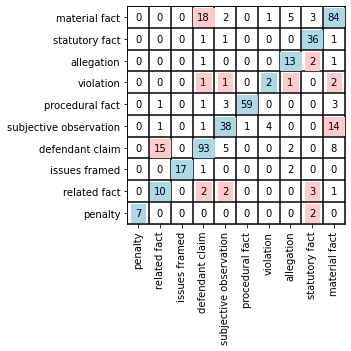

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


height, width = cm.shape
print(height)
print(width)

fig = plt.figure('confusion matrix')
ax = fig.add_subplot(111, aspect='equal')
for x in range(height):
    rowsum = 0
    for y in range(width):
      if x == y:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ADD8E6')
        rowsum += cm[width-x-1][height-y-1]
      else:
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center')
        rowsum += cm[width-x-1][height-y-1] 
    #print(f'row {x} sum is {rowsum}')
    for y in range(width):
      if x == y:
        pass
      elif cm[width-x-1][height-y-1] > int(0.1*rowsum):
        ax.annotate(str(cm[width-x-1][height-y-1]), xy=(y, x), ha='center', va='center',backgroundcolor='#ffcccb')
    

offset = .5    
ax.set_xlim(-offset, width - offset)
ax.set_ylim(-offset, height - offset)

ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)



plt.xticks(range(width), classes,rotation=90)
plt.yticks(range(height), classes)
plt.savefig('confusion_matrix.png', format='png')

In [ ]:
test_data['Label'].value_counts()

defendant claim           123
material fact             113
procedural fact            67
subjective observation     59
statutory fact             39
issues framed              20
related fact               18
allegation                 17
penalty                     9
violation                   7
Name: Label, dtype: int64